# Introduction

## Why Tuberculosis?
In the modern day of medicine, it takes a long time and is very expensive to get a medical evaluation. For some patients, getting information quickly and cheaply may mean the difference between life and death.

## How do we solve it?
In this project I attempt to perform 2 tasks. The first is to detect tuberculosis in the lungs and be able to quickly and accurately provide a response to a patient. While this approach may not be 100% accurate, it can help to provide early warning measures to patients that appear to have a higher chance for tuberculosis. 

The second task that I solve here has to do with solving the size of the xray imaging and ties into the first task. When passing these xrays into our model, we want a file that is as small as possible and contains few meaningless pixels. In order to do this I would like to apply masking to the xrays and then pass in the masked xray to the classifier.

## Where did the data come from?
The data was sourced from kaggle: https://www.kaggle.com/datasets/iamtapendu/chest-x-ray-lungs-segmentation/data

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa

2024-12-10 07:05:38.056585: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 07:05:38.125439: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 07:05:38.125471: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 07:05:38.125556: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 07:05:38.155968: I tensorflow/core/platform/cpu_feature_g

Create Cleaned directory for faster loading where mask is already applied

In [2]:
metaData = pd.read_csv('Data/Chest xrays/Chest-X-Ray/Chest-X-Ray/MetaData.csv')
metaData.head(5)

,id,gender,age,county,ptb,remarks
0,1000,male,31,Shenxhen,0,normal
1,1001,male,64,Shenxhen,0,normal
2,1002,male,35,Shenxhen,0,normal
3,1003,male,32,Shenxhen,1,"STB,ATB,tuberculosis pleuritis"
4,1004,male,2,Shenxhen,1,secondary PTB in the bilateral upper field


In [3]:
metaData["id"] = metaData["id"].astype(str)
metaData["id"]

0      1000
1      1001
2      1002
3      1003
4      1004
       ... 
699    1699
700    1700
701    1701
702    1702
703    1703
Name: id, Length: 704, dtype: object

In [4]:
from PIL import Image
ImageDir = 'Data/Chest xrays/Chest-X-Ray/Chest-X-Ray/image/'
heights = []
widths = []
for filename in os.listdir('Data/Chest xrays/Chest-X-Ray/Chest-X-Ray/PipelineData/0'):
    try:
        with Image.open(os.path.join('Data/Chest xrays/Chest-X-Ray/Chest-X-Ray/PipelineData/0/' + filename)) as img:
            width, height = img.size
            heights.append(height)
            widths.append(width)
    except Exception as e:
        print(f"Error processing {filename}: {e}")

for filename in os.listdir('Data/Chest xrays/Chest-X-Ray/Chest-X-Ray/PipelineData/1'):
    try:
        with Image.open(os.path.join('Data/Chest xrays/Chest-X-Ray/Chest-X-Ray/PipelineData/1/' + filename)) as img:
            width, height = img.size
            heights.append(height)
            widths.append(width)
    except Exception as e:
        print(f"Error processing {filename}: {e}")

heights = np.array(heights)
widths = np.array(widths)

data = {'height': heights, 'width': widths}
data = pd.DataFrame(data)

In [5]:
print(data.describe())

            height        width
count   704.000000   704.000000
mean   2115.696023  1943.603693
std     537.308546   550.915522
min     596.000000   700.000000
25%    1795.250000  1644.750000
50%    1997.500000  1761.000000
75%    2254.750000  1950.250000
max    4043.000000  3884.000000


As we can see, our Images are of vastly different sizes, therefore we will have to resize them either downscale or upscale.
We will try different sizes to see how our results will change.

# Part 1, Classification Training

## Load the Data as tensorflow Datasets

In [6]:
WIDTH = 256
HEIGHT = 256
BATCH_SIZE = 32
IMAGE_RESIZE = (WIDTH,HEIGHT)

trainData = tf.keras.utils.image_dataset_from_directory(
    'Data/Chest xrays/Chest-X-Ray/Chest-X-Ray/PipelineData',
    image_size=IMAGE_RESIZE,
    label_mode='binary',
    color_mode = 'grayscale',
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=42,
    interpolation='nearest'
)

validationData = tf.keras.utils.image_dataset_from_directory(
    'Data/Chest xrays/Chest-X-Ray/Chest-X-Ray/PipelineData',
    image_size=IMAGE_RESIZE,
    label_mode='binary',
    batch_size=BATCH_SIZE,
    color_mode = 'grayscale',
    validation_split=0.2,
    subset="validation",
    seed=42,
    interpolation='nearest'
)

Found 704 files belonging to 2 classes.
Using 564 files for training.


2024-12-10 07:05:47.329305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-10 07:05:47.514088: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-10 07:05:47.514118: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-10 07:05:47.519074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-10 07:05:47.519147: I tensorflow/compile

Found 704 files belonging to 2 classes.
Using 140 files for validation.


## EDA

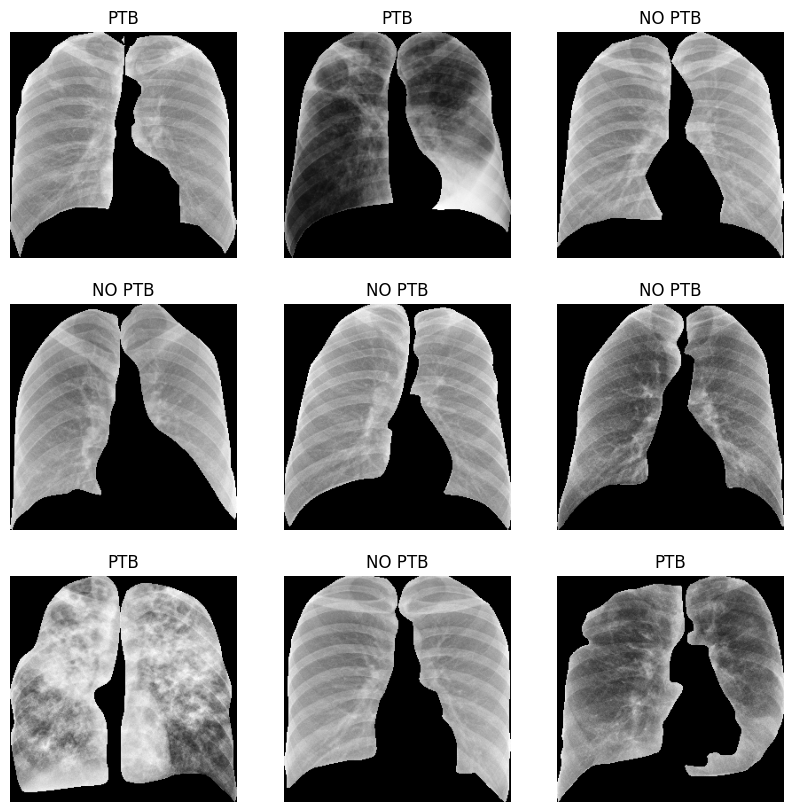

In [7]:
plt.figure(figsize=(10, 10))
i = 0
for images, labels in trainData.take(9):
    ax = plt.subplot(3, 3, i + 1)
    i+=1
    plt.imshow((images[0].numpy()), cmap='gray')
    ptb = "PTB" if labels[0].numpy().astype("uint8") == 1 else "NO PTB"
    plt.title(ptb)
    plt.axis("off")

## Data preprocessing

In [8]:
from tensorflow_addons.image import rotate
def random_augment(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.0 # rescale to 0-1
    noise = tf.random.normal(shape = tf.shape(image), mean=0.0, stddev=0.1, dtype=tf.float32) # add some random noise
    mask = tf.not_equal(image, 0.0)
    image = tf.where(mask, image + noise, image)
    image = tf.clip_by_value(image, 0, 1)
    image = tf.image.random_flip_left_right(image) # randomly flip the image left, right, up, and down
    # image = tf.image.random_flip_up_down(image)
    image = rotate(image, angles=tf.random.uniform([], minval=-0.2, maxval=0.2, dtype=tf.float32)) # randomly rotate the image
    return image, label

def rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.0 # rescale to 0-1
    return (image, label)

## Model Creation
For our model, we will be using a network with 3 convolution blocks connected by residuals.

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Rescaling, Input, Conv2D, Dropout, Concatenate, AveragePooling2D, GlobalAveragePooling2D, Dense, Flatten

In [10]:
modelInput = Input(shape=(HEIGHT, WIDTH, 1))

hiddenLayers = Conv2D(32, 3, activation='relu', padding='same')(modelInput)
hiddenLayers = Conv2D(32, 3, activation='relu', padding='same')(hiddenLayers)
hiddenLayers = Conv2D(32, 3, activation='relu', padding='same')(hiddenLayers)
hiddenLayers = AveragePooling2D(2, padding='same')(hiddenLayers)
hiddenLayers = Dropout(0.3)(hiddenLayers)

shortcut = hiddenLayers
hiddenLayers = Conv2D(64, 3, padding='same', activation='relu')(hiddenLayers)
hiddenLayers = Conv2D(64, 3, padding='same', activation='relu')(hiddenLayers)
hiddenLayers = Conv2D(64, 3, padding='same', activation='relu')(hiddenLayers)
hiddenLayers = Dropout(0.3)(hiddenLayers)
hiddenLayers = Concatenate()([hiddenLayers, shortcut])
hiddenLayers = AveragePooling2D(2, padding='same')(hiddenLayers)

shortcut = hiddenLayers
hiddenLayers = Conv2D(128, 3, padding='same', activation='relu')(hiddenLayers)
hiddenLayers = Conv2D(128, 3, padding='same', activation='relu')(hiddenLayers)
hiddenLayers = Conv2D(128, 3, padding='same', activation='relu')(hiddenLayers)
hiddenLayers = Dropout(0.3)(hiddenLayers)
hiddenLayers = Concatenate()([hiddenLayers, shortcut])


hiddenLayers = GlobalAveragePooling2D()(hiddenLayers)

hiddenLayers = Flatten()(hiddenLayers)
hiddenLayers = Dense(128, activation='relu')(hiddenLayers)
hiddenLayers = Dropout(0.3)(hiddenLayers)
modelOutput = Dense(1, activation='sigmoid')(hiddenLayers)

classificationModel = Model(inputs = modelInput, outputs= modelOutput)
classificationModel.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                    optimizer=tf.keras.optimizers.Nadam(), 
                   metrics=[tf.keras.metrics.BinaryAccuracy()])

## Train the model

In [11]:
trainRescaled = trainData.map(rescale)
validationRescaled = validationData.map(rescale)

In [12]:
import math
EPOCHS = 500
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',  # Metric to monitor for improvement
    patience=50,          # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore model weights to the best epoch
    start_from_epoch=15
)



modelHistory = classificationModel.fit(trainRescaled, validation_data=validationRescaled, epochs=EPOCHS,
                         callbacks = [early_stopping], 
                         steps_per_epoch = math.ceil(564 / BATCH_SIZE),
                         validation_steps = math.ceil(140 / BATCH_SIZE))

Epoch 1/500


2024-12-10 07:05:52.877798: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-12-10 07:05:54.320435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-12-10 07:05:59.128105: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd545603a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-10 07:05:59.128147: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-12-10 07:05:59.138813: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-10 07:05:59.234083: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled 

18/18 [==============================] - 14s 291ms/step - loss: 0.6934 - binary_accuracy: 0.5142 - val_loss: 0.6924 - val_binary_accuracy: 0.4929
Epoch 2/500
18/18 [==============================] - 4s 139ms/step - loss: 0.6936 - binary_accuracy: 0.5035 - val_loss: 0.6924 - val_binary_accuracy: 0.4929
Epoch 3/500
18/18 [==============================] - 3s 133ms/step - loss: 0.6933 - binary_accuracy: 0.5124 - val_loss: 0.6924 - val_binary_accuracy: 0.4929
Epoch 4/500
18/18 [==============================] - 3s 134ms/step - loss: 0.6930 - binary_accuracy: 0.5142 - val_loss: 0.6922 - val_binary_accuracy: 0.4929
Epoch 5/500
18/18 [==============================] - 4s 138ms/step - loss: 0.6922 - binary_accuracy: 0.5142 - val_loss: 0.6918 - val_binary_accuracy: 0.4929
Epoch 6/500
18/18 [==============================] - 3s 135ms/step - loss: 0.6922 - binary_accuracy: 0.5142 - val_loss: 0.6916 - val_binary_accuracy: 0.4929
Epoch 7/500
18/18 [==============================] - 4s 141ms/step - 

Now that we have trained a model that fairly accuractely predicts PTB in the lungs, we will now add some random noise to the images and continue to train to see if we can get further generability

In [13]:
EPOCHS = 500
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',  # Metric to monitor for improvement
    patience=50,          # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore model weights to the best epoch
    start_from_epoch=15
)
trainNoise = trainData.map(random_augment)
modelHistory = classificationModel.fit(trainNoise, validation_data=validationRescaled, epochs=EPOCHS,
                         callbacks = [early_stopping], 
                         steps_per_epoch = math.ceil(564 / BATCH_SIZE),
                         validation_steps = math.ceil(140 / BATCH_SIZE))

Epoch 1/500


2024-12-10 07:16:04.844435: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - 4s 137ms/step - loss: 0.5492 - binary_accuracy: 0.7429 - val_loss: 0.4539 - val_binary_accuracy: 0.7714
Epoch 2/500
18/18 [==============================] - 4s 139ms/step - loss: 0.4954 - binary_accuracy: 0.7695 - val_loss: 0.4931 - val_binary_accuracy: 0.7357
Epoch 3/500
18/18 [==============================] - 4s 139ms/step - loss: 0.4944 - binary_accuracy: 0.7819 - val_loss: 0.4536 - val_binary_accuracy: 0.7786
Epoch 4/500
18/18 [==============================] - 4s 136ms/step - loss: 0.4908 - binary_accuracy: 0.7695 - val_loss: 0.4425 - val_binary_accuracy: 0.8000
Epoch 5/500
18/18 [==============================] - 4s 137ms/step - loss: 0.4698 - binary_accuracy: 0.8050 - val_loss: 0.4564 - val_binary_accuracy: 0.7714
Epoch 6/500
18/18 [==============================] - 4s 139ms/step - loss: 0.4815 - binary_accuracy: 0.7855 - val_loss: 0.4586 - val_binary_accuracy: 0.7571
Epoch 7/500
18/18 [==============================] - 4s 141ms/step - l

## Results and Analysis

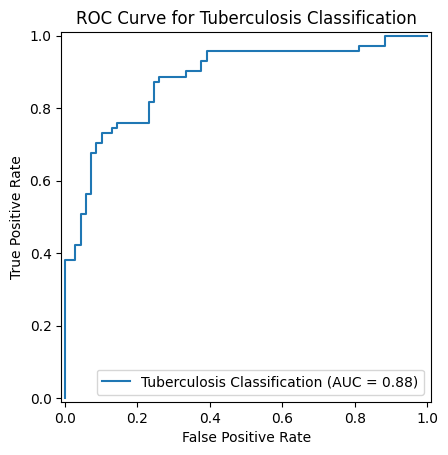

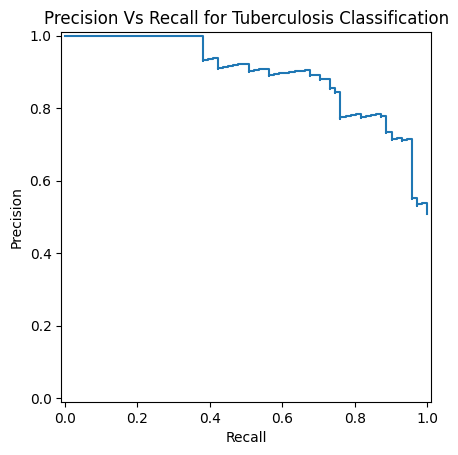

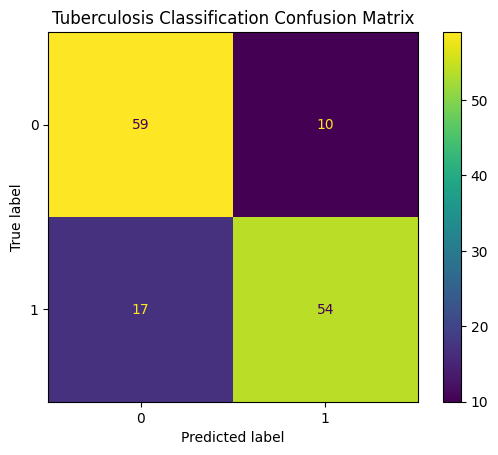

Precision score: 0.84375
Recall score: 0.7605633802816901


In [14]:
from sklearn import metrics
def modelPredictionsAsList(model, data):
    all_predictions_raw = []
    all_predictions_rounded = []
    y_true = []
    
    for X_batch, y_batch in data:
        y_true += y_batch.numpy().astype("uint8").tolist()
        predictions = model.predict(X_batch, verbose=0)
        predictions = predictions.reshape(len(X_batch),)
        all_predictions_raw += predictions.tolist()
        all_predictions_rounded += np.round(predictions).tolist()
    
    return (all_predictions_raw, all_predictions_rounded, y_true)


def displayMetrics(model, data, modelName):
    rawPredictions, roundedPredictions, y_true = modelPredictionsAsList(model, data)
    y_true = np.array(y_true)[:,0]
    fpr, tpr, thresholds = metrics.roc_curve(y_true, rawPredictions)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr = fpr, tpr=tpr, roc_auc = roc_auc, estimator_name = modelName)
    display.plot()
    plt.title("ROC Curve for {}".format(modelName))
    plt.show()
    precision, recall, _ = metrics.precision_recall_curve(y_true, rawPredictions)
    disp = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.title("Precision Vs Recall for {}".format(modelName))
    plt.show()

    metrics.ConfusionMatrixDisplay.from_predictions(y_true, roundedPredictions)
    plt.title("{} Confusion Matrix".format(modelName))
    plt.show()

    print("Precision score: {}\nRecall score: {}".format(
        metrics.precision_score(y_true, roundedPredictions), metrics.recall_score(y_true, roundedPredictions)
    ))

displayMetrics(classificationModel, validationRescaled, "Tuberculosis Classification")


# Part 2, Lung Segmentation
In this section we will be attempting to make our own masking image. The process for detecting tuberculosis is significantly slowed down if every time an xray is taken, a doctor still has to outline the lungs to create a masking image. Because of this we will attempt to speed up the process by accurately creating our own masking images that we can use. 

# Load in Data
The data we are going to be loading in is the original xray image and the masking image provided to us.

In [15]:
ImageDir = 'Data/Chest xrays/Chest-X-Ray/Chest-X-Ray/image/'
MaskDir = 'Data/Chest xrays/Chest-X-Ray/Chest-X-Ray/mask/'

TARGET_SIZE = (512,512)
BATCH_SIZE = 1

def load_segmentation_dataset(input_img_path, target_img_path):
    input_img = tf.io.read_file(input_img_path)
    input_img = tf.io.decode_png(input_img, channels = 1)
    input_img = tf.image.resize(input_img, TARGET_SIZE, method="nearest")
    input_img = tf.image.convert_image_dtype(input_img, "float32")

    target_img = tf.io.read_file(target_img_path)
    target_img = tf.io.decode_png(target_img, channels = 1)
    target_img = tf.image.resize(target_img, TARGET_SIZE, method="nearest")
    target_img = tf.image.convert_image_dtype(target_img, "float32")

    return input_img, target_img

In [16]:
import random

inputPath = sorted([
    os.path.join(ImageDir, fname)
    for fname in os.listdir(ImageDir)
    if fname.endswith(".png")
])
targetPath = sorted([
    os.path.join(MaskDir, fname)
    for fname in os.listdir(MaskDir)
    if fname.endswith(".png")
])

random.Random(42).shuffle(inputPath)
random.Random(42).shuffle(targetPath)

VALIDATE_SIZE = 0.2

trainInputPath = inputPath[:int(len(inputPath) * (1-VALIDATE_SIZE))]
trainTargetPath = targetPath[:int(len(targetPath) * (1-VALIDATE_SIZE))]

validateInputPath = inputPath[int(len(inputPath) * (1-VALIDATE_SIZE)):]
validateTargetPath = targetPath[int(len(targetPath) * (1-VALIDATE_SIZE)):]

def get_dataset(batch_size, img_size, inputPath, targetPath):
    dataset = tf.data.Dataset.from_tensor_slices((inputPath, targetPath))
    dataset = dataset.map(load_segmentation_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(BATCH_SIZE)

trainData = get_dataset(32, TARGET_SIZE, trainInputPath, trainTargetPath)
validateData = get_dataset(32, TARGET_SIZE, validateInputPath, validateTargetPath)

## View the data

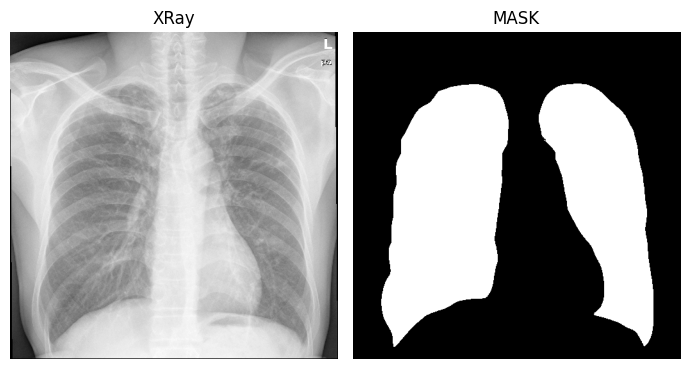

In [17]:
for orig, mask in trainData.take(1):
    fig, axes = plt.subplots(1, 2, figsize = (7,7))
    axes = np.expand_dims(axes, axis=0)
    axes[0,0].imshow(orig[0], cmap='gray')
    axes[0,0].set_title("XRay")
    axes[0,0].axis('off')
    axes[0,1].imshow(mask[0], cmap='gray')
    axes[0,1].set_title("MASK")
    axes[0,1].axis('off')
    plt.tight_layout()
    plt.show()

# Model Creation
We will be using a form of Unet since it is very popular for medical image segmentation tasks.

In [18]:
def myUNET():
    inputLayer = tf.keras.layers.Input(shape = (512, 512, 1))

    hiddenLayer = tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=2, padding = 'same')(inputLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (256, 256, 64)
    shortcut1 = hiddenLayer

    hiddenLayer = tf.keras.layers.Conv2D(filters = 128, kernel_size = 4, strides = 2, padding = 'same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (128, 128, 128)
    shortcut2 = hiddenLayer

    hiddenLayer = tf.keras.layers.Conv2D(filters = 256, kernel_size = 4, strides = 2, padding = 'same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (64, 64, 256)
    shortcut3 = hiddenLayer

    hiddenLayer = tf.keras.layers.Conv2D(filters = 512, kernel_size = 4, strides = 2, padding = 'same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (32, 32, 512)
    shortcut4 = hiddenLayer

    bottleNeck = tf.keras.layers.Conv2D(filters = 512, kernel_size = 3, strides = 1, padding = 'same')(hiddenLayer)
    bottleNeck = tf.keras.layers.Conv2D(filters = 512, kernel_size = 3, strides = 1, padding = 'same')(bottleNeck)
    bottleNeck = tf.keras.layers.Conv2D(filters = 512, kernel_size = 3, strides = 1, padding = 'same')(bottleNeck)
    
    decodeLayer = tf.keras.layers.Add()([bottleNeck, shortcut4])
    decodeLayer = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=4, strides=2, padding='same')(decodeLayer)
    decodeLayer = tfa.layers.InstanceNormalization()(decodeLayer)
    decodeLayer = tf.keras.layers.ReLU()(decodeLayer)  # outpus (64, 64, 256)

    decodeLayer = tf.keras.layers.Add()([decodeLayer, shortcut3])
    decodeLayer = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding='same')(decodeLayer)
    decodeLayer = tfa.layers.InstanceNormalization()(decodeLayer)
    decodeLayer = tf.keras.layers.ReLU()(decodeLayer)

    decodeLayer = tf.keras.layers.Add()([decodeLayer, shortcut2])
    decodeLayer = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=2, padding='same')(decodeLayer)
    decodeLayer = tfa.layers.InstanceNormalization()(decodeLayer)
    decodeLayer = tf.keras.layers.ReLU()(decodeLayer)

    decodeLayer = tf.keras.layers.Add()([decodeLayer, shortcut1])
    outputLayer = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=4, strides=2, padding='same' ,activation='sigmoid')(decodeLayer)

    return tf.keras.models.Model(inputs = inputLayer, outputs = outputLayer)

segmentModel = myUNET()
# temp.summary()

In [19]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',  # Metric to monitor for improvement
    patience=15,          # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore model weights to the best epoch
)

segmentModel.compile(optimizer=tf.keras.optimizers.Adam(), loss= tf.keras.losses.BinaryCrossentropy(), metrics=tf.keras.metrics.BinaryAccuracy())
segmentModel.fit(trainData, epochs = 300, validation_data = validateData, callbacks=[earlystop])

Epoch 1/300
563/563 [==============================] - 17s 23ms/step - loss: 0.1816 - binary_accuracy: 0.9312 - val_loss: 0.1589 - val_binary_accuracy: 0.9406
Epoch 2/300
563/563 [==============================] - 13s 23ms/step - loss: 0.1021 - binary_accuracy: 0.9629 - val_loss: 0.1241 - val_binary_accuracy: 0.9543
Epoch 3/300
563/563 [==============================] - 13s 23ms/step - loss: 0.0902 - binary_accuracy: 0.9674 - val_loss: 0.0993 - val_binary_accuracy: 0.9626
Epoch 4/300
563/563 [==============================] - 13s 23ms/step - loss: 0.0814 - binary_accuracy: 0.9705 - val_loss: 0.0845 - val_binary_accuracy: 0.9684
Epoch 5/300
563/563 [==============================] - 13s 23ms/step - loss: 0.0753 - binary_accuracy: 0.9726 - val_loss: 0.0738 - val_binary_accuracy: 0.9729
Epoch 6/300
563/563 [==============================] - 13s 23ms/step - loss: 0.0705 - binary_accuracy: 0.9743 - val_loss: 0.0710 - val_binary_accuracy: 0.9739
Epoch 7/300
563/563 [=========================

# Results and Analysis

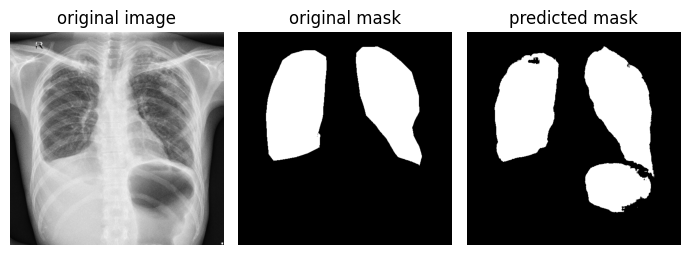

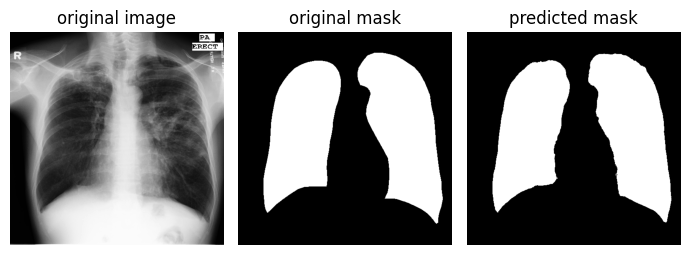

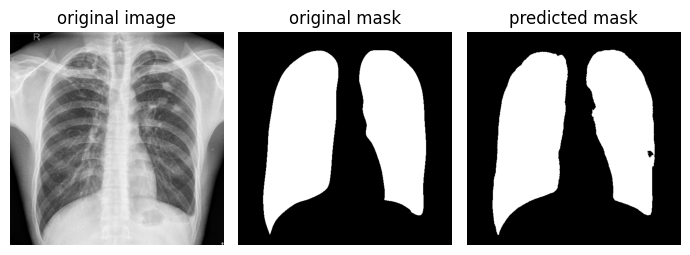

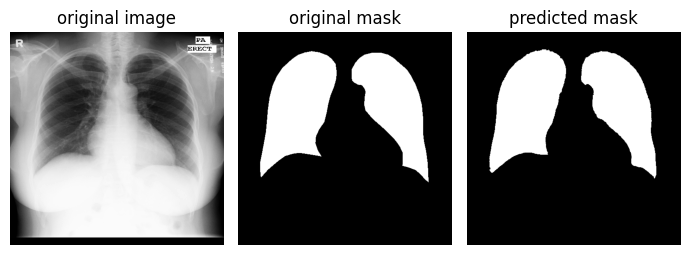

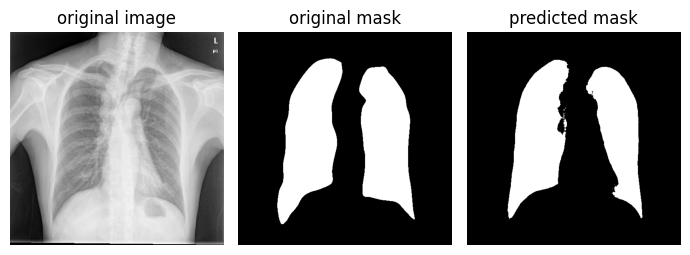

In [20]:
for img, mask in validateData.take(5):
    fig, axes = plt.subplots(1, 3, figsize = (7,7))
    axes = np.expand_dims(axes, axis=0)
    
    prediction = segmentModel.predict(img, verbose=0)
    
    axes[0,0].imshow(img[0], cmap = 'gray')
    axes[0,0].set_title("original image")
    axes[0,0].axis('off')
    
    axes[0,1].imshow(mask[0], cmap = 'gray')
    axes[0,1].set_title("original mask")
    axes[0,1].axis('off')
    
    axes[0,2].imshow(np.round(prediction[0]), cmap = 'gray')
    axes[0,2].set_title("predicted mask")
    axes[0,2].axis('off')
    
    plt.tight_layout()
    plt.show()

## Export predicted mappings to new directory

In [21]:
BATCH_SIZE = 32
TARGET_SIZE = (512, 512)

def finalMap(input_img_path):
    input_img = tf.io.read_file(input_img_path)
    input_img = tf.io.decode_png(input_img, channels = 1)
    input_img = tf.image.resize(input_img, TARGET_SIZE, method="nearest")
    input_img = tf.image.convert_image_dtype(input_img, "float32")
    return input_img

inputPath = sorted([
    os.path.join(ImageDir, fname)
    for fname in os.listdir(ImageDir)
    if fname.endswith(".png")
])


def get_dataset(batch_size, img_size, inputPath):
    dataset = tf.data.Dataset.from_tensor_slices(inputPath)
    dataset = dataset.map(finalMap, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(BATCH_SIZE)

tempData = get_dataset(32, TARGET_SIZE, inputPath)

In [22]:
prediction = segmentModel.predict(tempData)

22/22 [==============================] - 8s 236ms/step


In [23]:
os.makedirs('Data/Chest xrays/Chest-X-Ray/Chest-X-Ray/PredictedMasking/0', exist_ok=True)
os.makedirs('Data/Chest xrays/Chest-X-Ray/Chest-X-Ray/PredictedMasking/1', exist_ok=True)

for i in range(0,prediction.shape[0]):
    mask = np.round(prediction[i])
    mask = tf.image.convert_image_dtype(mask, "uint8")
    fileName = inputPath[i].split("/")[-1]
    image = tf.io.read_file(inputPath[i])
    image = tf.io.decode_png(image, channels=1)
    image = tf.image.resize(image, (512,512), method="nearest")

    retval = image * mask
    
    # Remove black rows (all zeros) - check along axis 1 (rows)
    black_rows = tf.reduce_all(tf.equal(retval, 0), axis=1)  # Boolean mask for black rows
    black_rows_indices = tf.where(black_rows == False)  # Get the indices of non-black rows
    retval = tf.gather(retval, black_rows_indices[:, 0], axis=0)  # Select non-black rows

    # Remove black columns (all zeros) - check along axis 0 (columns)
    black_cols = tf.reduce_all(tf.equal(retval, 0), axis=0)  # Boolean mask for black columns
    black_cols_indices = tf.where(black_cols == False)  # Get the indices of non-black columns
    retval = tf.gather(retval, black_cols_indices[:, 0], axis=1)  # Select non-black columns

    retval = tf.io.encode_png(retval)
    
    if (metaData[(metaData['id'] + '.png') == fileName]['ptb'].values[0] == 0):
        outputDir = 'Data/Chest xrays/Chest-X-Ray/Chest-X-Ray/PredictedMasking/0'
        output_path = os.path.join(outputDir, fileName)
        tf.io.write_file(output_path, retval)
    elif (metaData[(metaData['id'] + '.png') == fileName]['ptb'].values[0] == 1):
        outputDir = 'Data/Chest xrays/Chest-X-Ray/Chest-X-Ray/PredictedMasking/1'
        output_path = os.path.join(outputDir, fileName)
        tf.io.write_file(output_path, retval)

# Part 3, putting it all together

In [24]:
FinalData = tf.keras.utils.image_dataset_from_directory(
    'Data/Chest xrays/Chest-X-Ray/Chest-X-Ray/PredictedMasking',
    image_size=(256,256),
    label_mode='binary',
    color_mode = 'grayscale',
    batch_size=32,
    interpolation='nearest'
)
FinalData = FinalData.map(rescale)

Found 704 files belonging to 2 classes.


In [25]:
classificationModel.evaluate(FinalData)

22/22 [==============================] - 1s 40ms/step - loss: 0.9705 - binary_accuracy: 0.4716


[0.9705097675323486, 0.47159090638160706]

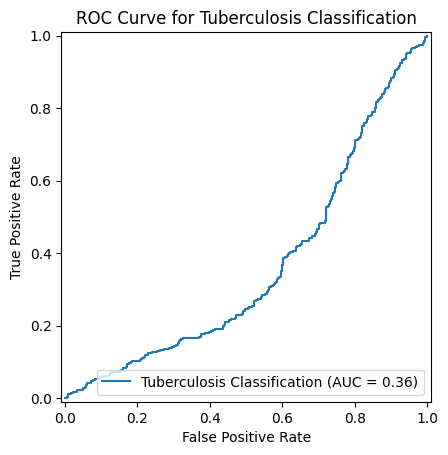

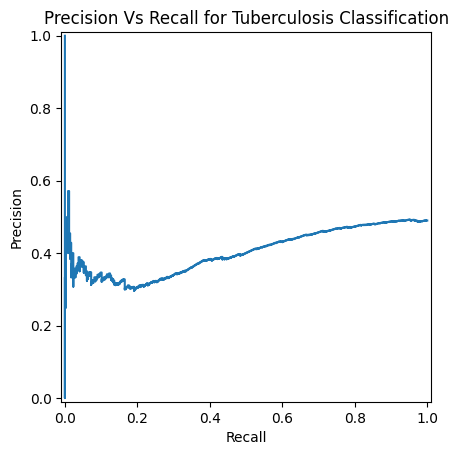

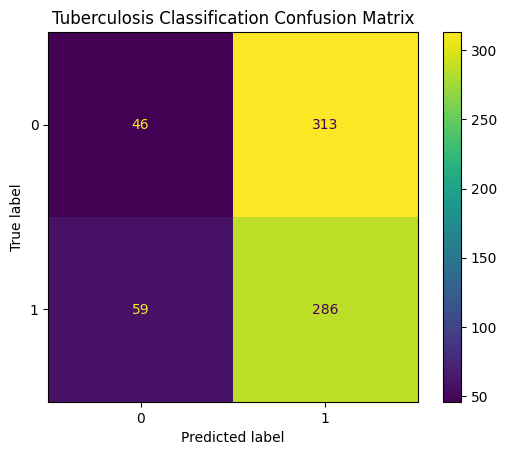

Precision score: 0.4774624373956594
Recall score: 0.8289855072463768


In [26]:
displayMetrics(classificationModel, FinalData, "Tuberculosis Classification")

Unfortunately our model does not do well in predicting if there is tuberculosis from our predicted masking, and therefore we will attempt to retrain the model with our new data. The current model tends to almost always predict tuberculosis. We will use the previous model's weights still as a starting ground in the hopes that it started to learn the patern for detecting Tuberculosis, however may have been overfit.

In [27]:
trainData2 = tf.keras.utils.image_dataset_from_directory(
    'Data/Chest xrays/Chest-X-Ray/Chest-X-Ray/PredictedMasking',
    image_size=(256,256),
    label_mode='binary',
    color_mode = 'grayscale',
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed=42,
    interpolation='nearest'
)

validationData2 = tf.keras.utils.image_dataset_from_directory(
    'Data/Chest xrays/Chest-X-Ray/Chest-X-Ray/PredictedMasking',
    image_size=(256,256),
    label_mode='binary',
    batch_size=32,
    color_mode = 'grayscale',
    validation_split=0.2,
    subset="validation",
    seed=42,
    interpolation='nearest'
)
trainData2 = trainData2.map(rescale)
validationData2 = validationData2.map(rescale)

Found 704 files belonging to 2 classes.
Using 564 files for training.
Found 704 files belonging to 2 classes.
Using 140 files for validation.


In [28]:
EPOCHS = 500
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',  # Metric to monitor for improvement
    patience=50,          # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore model weights to the best epoch
    start_from_epoch=15
)
classificationModel.fit(trainData2, validation_data=validationData2, epochs=EPOCHS,
                         callbacks = [early_stopping], 
                         steps_per_epoch = math.ceil(564 / 32),
                         validation_steps = math.ceil(140 / 32))

Epoch 1/500
18/18 [==============================] - 2s 112ms/step - loss: 0.7006 - binary_accuracy: 0.6702 - val_loss: 0.6160 - val_binary_accuracy: 0.7143
Epoch 2/500
18/18 [==============================] - 3s 148ms/step - loss: 0.5911 - binary_accuracy: 0.7181 - val_loss: 0.6004 - val_binary_accuracy: 0.7214
Epoch 3/500
18/18 [==============================] - 2s 117ms/step - loss: 0.5917 - binary_accuracy: 0.7287 - val_loss: 0.5960 - val_binary_accuracy: 0.7286
Epoch 4/500
18/18 [==============================] - 2s 112ms/step - loss: 0.5771 - binary_accuracy: 0.7323 - val_loss: 0.5663 - val_binary_accuracy: 0.7286
Epoch 5/500
18/18 [==============================] - 2s 113ms/step - loss: 0.5716 - binary_accuracy: 0.7411 - val_loss: 0.5727 - val_binary_accuracy: 0.7286
Epoch 6/500
18/18 [==============================] - 2s 127ms/step - loss: 0.5715 - binary_accuracy: 0.7411 - val_loss: 0.5551 - val_binary_accuracy: 0.7357
Epoch 7/500
18/18 [==============================] - 2s 11

In [29]:
classificationModel.evaluate(validationData2)

5/5 [==============================] - 0s 29ms/step - loss: 0.5196 - binary_accuracy: 0.8071


[0.5195650458335876, 0.8071428537368774]

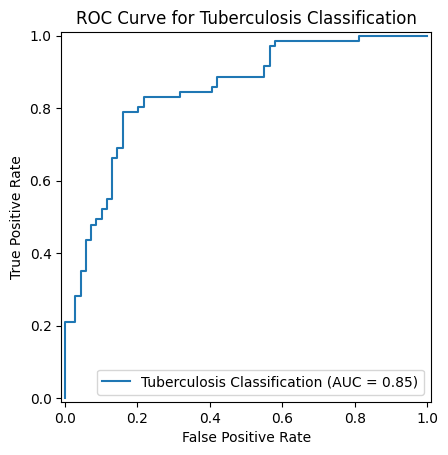

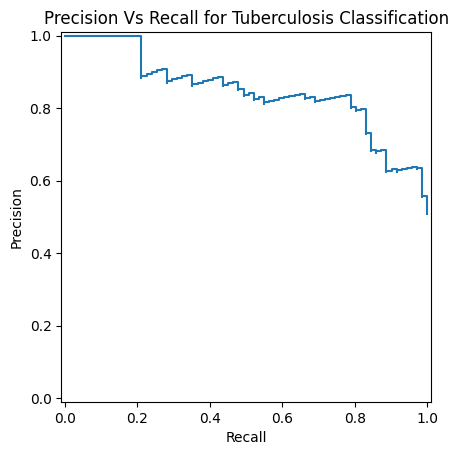

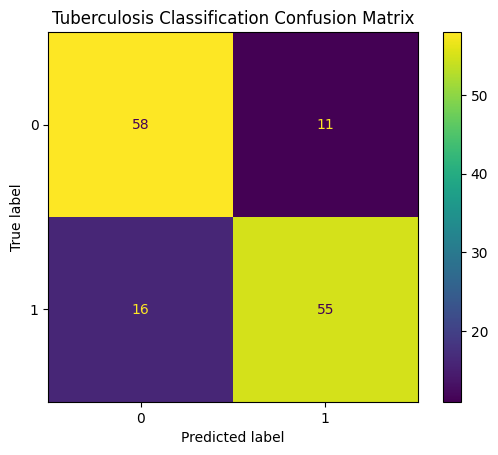

Precision score: 0.8333333333333334
Recall score: 0.7746478873239436


In [30]:
displayMetrics(classificationModel, validationData2, "Tuberculosis Classification")

# Discussion and Conclusions
As we can see, my initial approach to training a classifier model with the given masked data and then applying that model to the predicted mask data did not work as intended. It only achieved an accuracy of about 50% which is the equivelant of just guessing. However after I continued training the same model on the predicted maskings, the accuracy increased to about 80%. My masking binary accuracy was close to 98% and that caused me to think that the maskings we used in training the initial classifier and the predicted maskings would have about the same result. This was not the case and could be due to the large amount of black pixels causing the masking accuracy to show higher than it realistically should have been. The predicted masking may have also left out areas that revealed tuberculosis which caused my model to incorrectly classify images.

## Limitations
One of the limitations for this project was the data set size. There were only 704 images in the whole dataset which can cause the models to overfit. Another limitation was the amount of previous experience I have had with masking image data. This project had limited methods applied and there may be more research on better methods.

## Future
In the future I would like to explore using images at a higher resolution since most of them came at about 3000x3000 pixels and i decreased them to about 256x256. I would also like to discover better metrics or loss functions that could be used to not give misleading high accuracy values. Lastly I would like to find more methods to prevent overfitting (may have to do with small dataset size) since in both cases our classification model began to drastically overfit the data and decrease the accuracy of the validation set.